In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import time



In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/mask_data_photos/highres.tgz"
data_dir = tf.keras.utils.get_file('highres', origin=dataset_url,untar = True)
data_dir = pathlib.Path(data_dir)

151142400/151142400 [==============================] - 1s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2387


In [ ]:
yes = list(data_dir.glob('yes/*'))
PIL.Image.open(str(yes[0]))
no = list(data_dir.glob('no/*'))
#PIL.Image.open(str(no[0]))


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 2388 files belonging to 2 classes.
Using 1911 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2388 files belonging to 2 classes.
Using 477 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


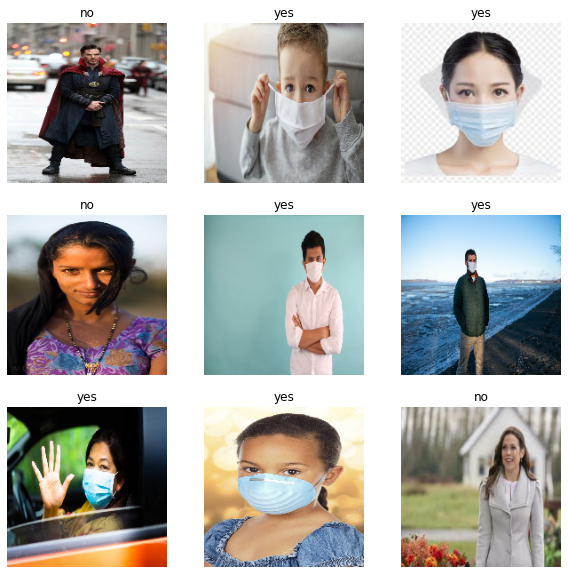

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:


data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
num_classes = 2

#regularizing by 
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
"""plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")"""

'plt.figure(figsize=(10, 10))\nfor images, _ in train_ds.take(1):\n  for i in range(9):\n    augmented_images = data_augmentation(images)\n    ax = plt.subplot(3, 3, i + 1)\n    plt.imshow(augmented_images[0].numpy().astype("uint8"))\n    plt.axis("off")'

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 128)      

In [ ]:
epochs = 4
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/4
60/60 [==============================] - 126s 2s/step - loss: 0.0568 - accuracy: 0.9780 - val_loss: 0.9857 - val_accuracy: 0.7715
Epoch 2/4
60/60 [==============================] - 126s 2s/step - loss: 0.0421 - accuracy: 0.9864 - val_loss: 1.3450 - val_accuracy: 0.7904
Epoch 3/4
60/60 [==============================] - 125s 2s/step - loss: 0.0546 - accuracy: 0.9796 - val_loss: 1.4421 - val_accuracy: 0.7715
Epoch 4/4
60/60 [==============================] - 126s 2s/step - loss: 0.0619 - accuracy: 0.9827 - val_loss: 1.3214 - val_accuracy: 0.7736


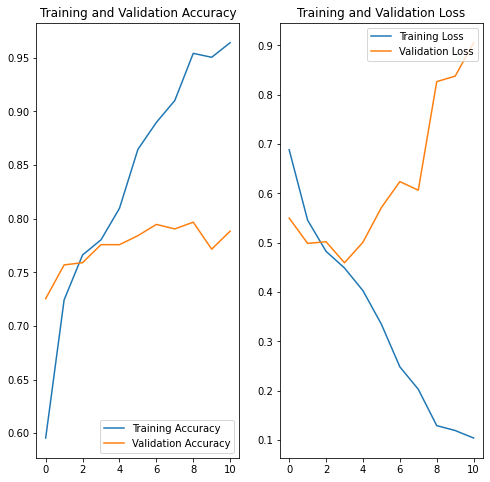

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This image most likely belongs to no with a 52.49 percent confidence.
0.1131751537322998
tf.Tensor([0.5248804  0.47511962], shape=(2,), dtype=float32)


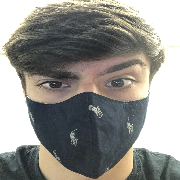

In [ ]:
sunflower_url = "https://storage.googleapis.com/mask_data_photos/TestImages/Screen%20Shot%202021-07-02%20at%201.39.12%20PM.png"
sunflower_path = tf.keras.utils.get_file('ImageWeTest', origin=sunflower_url)

dexterDogTimer = time.time()
img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print(time.time() - dexterDogTimer)
print(score)

img

In [ ]:
model.save('mymodel.h5',model)